In [5]:
import sys
import os
sys.path.append('../../')

%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.io import imread

from gen.load_data import load_data

In [3]:
from sklearn.utils import shuffle

train_df, valid_df, test_df = load_data('../../data')

train_df = shuffle(train_df)
valid_df = shuffle(valid_df)

print(train_df.head())


                                                  image                   id  \
1650                 ../../data/Train/CameraRGB/270.png                  270   
3562  ../../data/Train/CameraRGB/episode_0007_000119...  episode_0007_000119   
4618  ../../data/Train/CameraRGB/episode_0005_000195...  episode_0005_000195   
3818  ../../data/Train/CameraRGB/episode_0011_000120...  episode_0011_000120   
3015                 ../../data/Train/CameraRGB/889.png                  889   

                                                  label  
1650                 ../../data/Train/CameraSeg/270.png  
3562  ../../data/Train/CameraSeg/episode_0007_000119...  
4618  ../../data/Train/CameraSeg/episode_0005_000195...  
3818  ../../data/Train/CameraSeg/episode_0011_000120...  
3015                 ../../data/Train/CameraSeg/889.png  


In [4]:
from models.fcn8 import model_fcn8

model = model_fcn8(12, image_shape=(480, 480, 3), keep_prob=0.5)
model.summary()

/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 480, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 480, 480, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 480, 480, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 240, 240, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [6]:
from gen.datagen import balanced_generator_from_df

BATCH_SIZE = 32

model_dir = '../../saved_models/fcn8/fcn8_v4/'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)


train_gen = balanced_generator_from_df(train_df, BATCH_SIZE, (480, 480))
valid_gen = balanced_generator_from_df(valid_df, BATCH_SIZE, (480, 480))


In [7]:
from train import jaccard_distance_loss
from keras.utils.training_utils import multi_gpu_model
from keras.optimizers import RMSprop

gpus = 2

opt = RMSprop(lr=1e-04)
model_gpu = multi_gpu_model(model, gpus)
model_gpu.compile(loss=jaccard_distance_loss,
              optimizer=opt,
              metrics=['acc'])


In [8]:
from train import train_nn

m = train_df.shape[0]
history = train_nn(model_gpu, 
                   train_gen, 
                   valid_gen, 
                   training_size=m, 
                   batch_size=BATCH_SIZE,
                   validation_size=valid_df.shape[0],
                   output_path=model_dir, 
                   epochs=100,
                  gpus = 2)

Instructions for updating:
Use the retry module or similar alternatives.
Epoch 1/100
75/75 [==============================] - 142s 2s/step - loss: 1.2128 - acc: 0.3818 - val_loss: 0.8200 - val_acc: 0.5818

Epoch 00001: val_loss improved from inf to 0.82005, saving model to ../../saved_models/fcn8/fcn8_v4//model.hdf5
Epoch 2/100
75/75 [==============================] - 133s 2s/step - loss: 0.5522 - acc: 0.7184 - val_loss: 0.5232 - val_acc: 0.7332

Epoch 00002: val_loss improved from 0.82005 to 0.52320, saving model to ../../saved_models/fcn8/fcn8_v4//model.hdf5
Epoch 3/100
75/75 [==============================] - 132s 2s/step - loss: 0.3413 - acc: 0.8259 - val_loss: 0.4043 - val_acc: 0.7938

Epoch 00003: val_loss improved from 0.52320 to 0.40426, saving model to ../../saved_models/fcn8/fcn8_v4//model.hdf5
Epoch 4/100
75/75 [==============================] - 133s 2s/step - loss: 0.2452 - acc: 0.8749 - val_loss: 0.3259 - val_acc: 0.8338

Epoch 00004: val_loss improved from 0.40426 to 0.32

75/75 [==============================] - 134s 2s/step - loss: 0.0659 - acc: 0.9664 - val_loss: 0.1912 - val_acc: 0.9025

Epoch 00077: val_loss did not improve
Epoch 78/100
75/75 [==============================] - 133s 2s/step - loss: 0.0655 - acc: 0.9666 - val_loss: 0.1935 - val_acc: 0.9013

Epoch 00078: val_loss did not improve
Epoch 79/100
75/75 [==============================] - 132s 2s/step - loss: 0.0644 - acc: 0.9672 - val_loss: 0.1900 - val_acc: 0.9031

Epoch 00079: val_loss did not improve
Epoch 80/100
75/75 [==============================] - 134s 2s/step - loss: 0.0630 - acc: 0.9679 - val_loss: 0.1864 - val_acc: 0.9049

Epoch 00080: val_loss improved from 0.18965 to 0.18639, saving model to ../../saved_models/fcn8/fcn8_v4//model.hdf5
Epoch 81/100
75/75 [==============================] - 132s 2s/step - loss: 0.0628 - acc: 0.9680 - val_loss: 0.1881 - val_acc: 0.9041

Epoch 00081: val_loss did not improve
Epoch 82/100
75/75 [==============================] - 131s 2s/step - loss: 

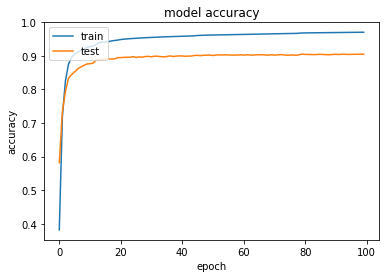

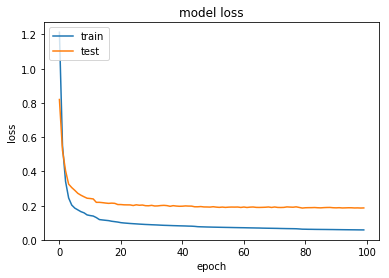

In [9]:
# # summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
model.save('../../saved_models/fcn8/fcn8_v4/fcn8_v4.h5')

In [ ]:
#valid_gen = train_and_lab_gen_func(valid_df, image_size=(600, 800), target_size=(480, 480), batch_size = BATCH_SIZE * gpus)
#test_gen = train_and_lab_gen_func(test_df, image_size=(600, 800),  target_size=(480, 480),  batch_size = BATCH_SIZE * gpus)